In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import streamlit as st

In [2]:
def generate_synthetic_data(n_samples=1000, n_features=10, random_state=42):
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=7,
        n_redundant=2,
        n_classes=2,
        weights=[0.7, 0.3],
        random_state=random_state
    )
    feature_names = [f"Feature_{i}" for i in range(1, n_features + 1)]
    data = pd.DataFrame(X, columns=feature_names)
    data['Credit_Risk'] = y
    return data


In [12]:
##vizz
def visualize_data(data):
    sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Correlation Heatmap")
    plt.show()

    for column in data.drop("Credit_Risk", axis=1).columns:
        sns.histplot(data, x=column, hue="Credit_Risk", kde=True, palette="Set1")
        plt.title(f"Feature Distribution: {column}")
        plt.show()

def plot_roc_curve(y_test, y_proba, model_name):
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc_score(y_test, y_proba):.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

def create_dashboard(data, model, scaler):
    st.title("Credit Risk Analysis Dashboard")

    st.header("Dataset Overview")
    st.dataframe(data.head())

    st.header("Feature Correlation Heatmap")
    corr_fig = sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap="coolwarm")
    st.pyplot(corr_fig.figure)

    st.header("Make Predictions")
    user_input = {}
    for col in data.drop("Credit_Risk", axis=1).columns:
        user_input[col] = st.number_input(f"{col}", value=0.0)

    user_df = pd.DataFrame([user_input])
    scaled_input = scaler.transform(user_df)
    prediction = model.predict(scaled_input)[0]
    st.write(f"Predicted Credit Risk: {'High Risk' if prediction == 1 else 'Low Risk'}")



In [14]:
# Load and split data
def prepare_data(data):
    X = data.drop("Credit_Risk", axis=1)
    y = data["Credit_Risk"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    # Ensure all five values are returned
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

In [6]:
# Train Logistic Regression model
def train_logistic_regression(X_train, y_train):
    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)
    return model


In [7]:
# Train Random Forest model
def train_random_forest(X_train, y_train):
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    return model


In [16]:
# Evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):  # Check if the model has `predict_proba`
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = None  # For models without `predict_proba`, set to None
    report = classification_report(y_test, y_pred, output_dict=True)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    return report, auc, y_proba



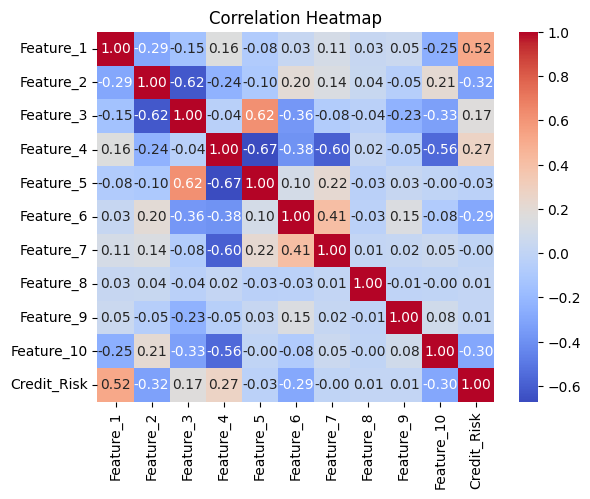

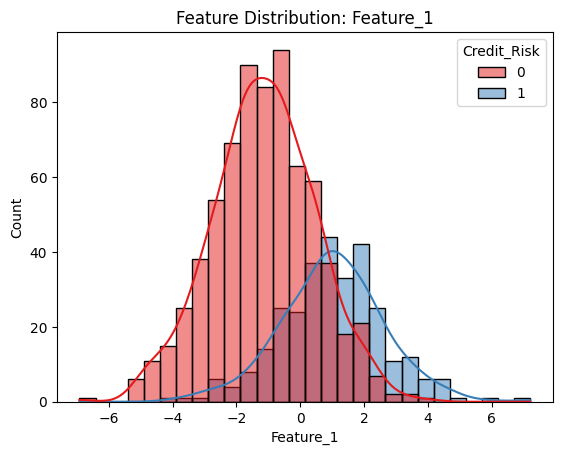

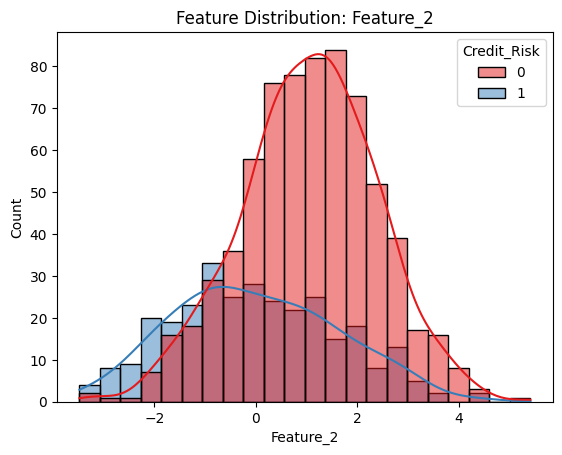

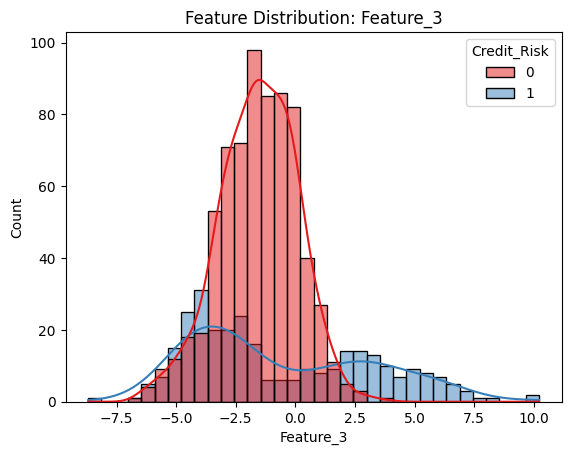

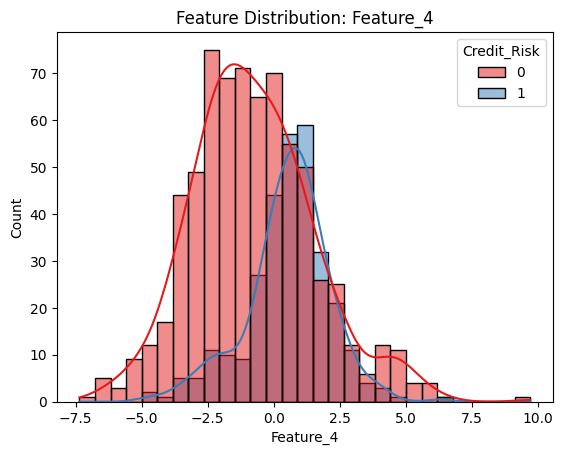

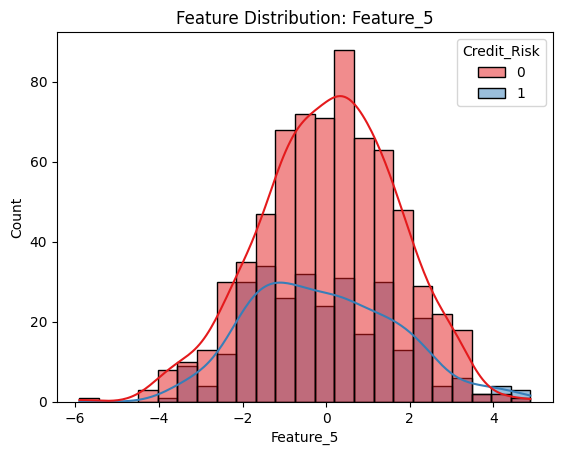

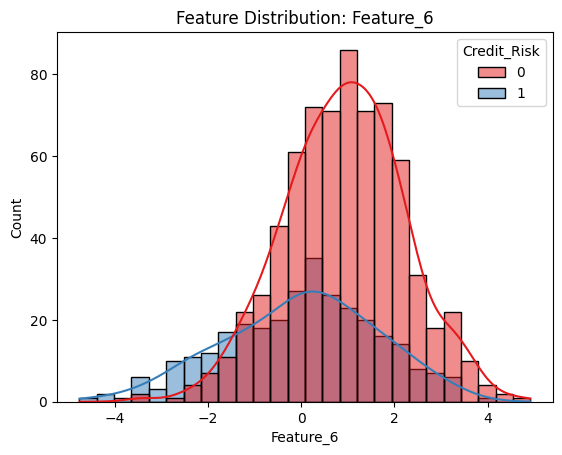

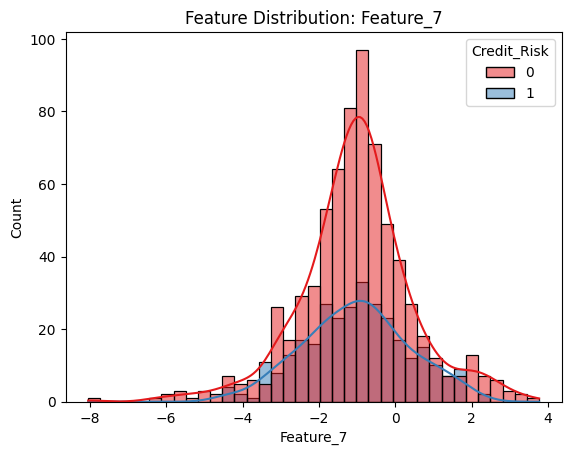

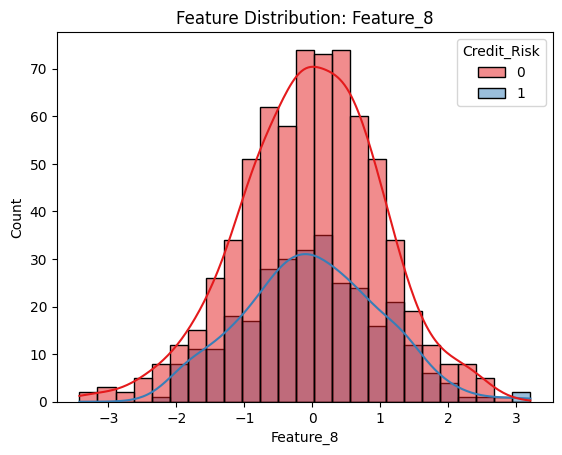

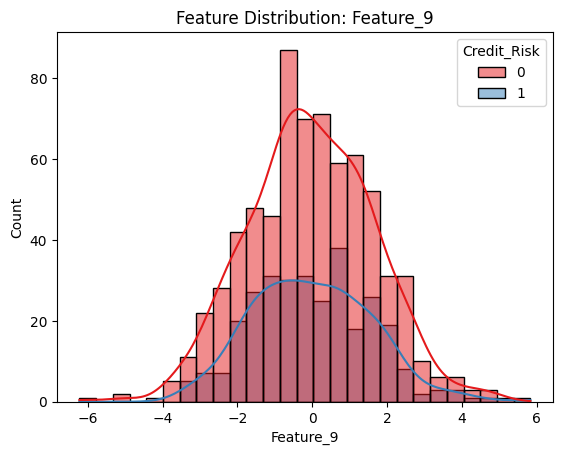

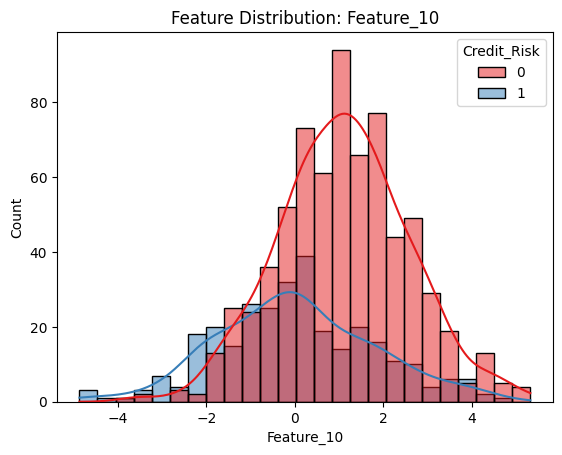

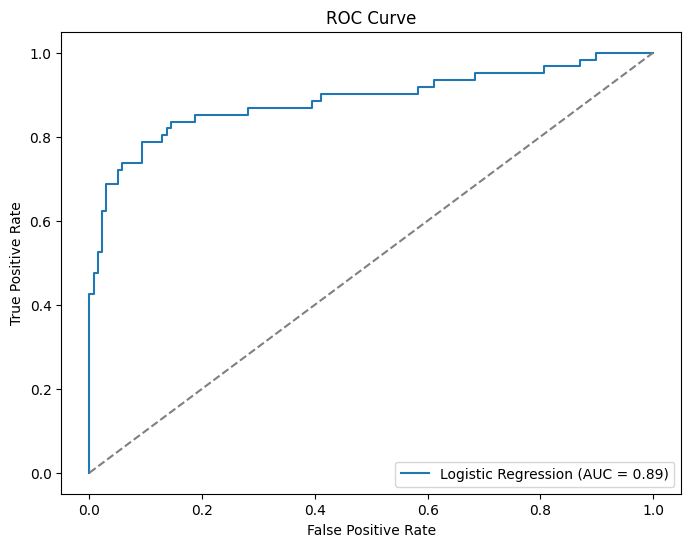

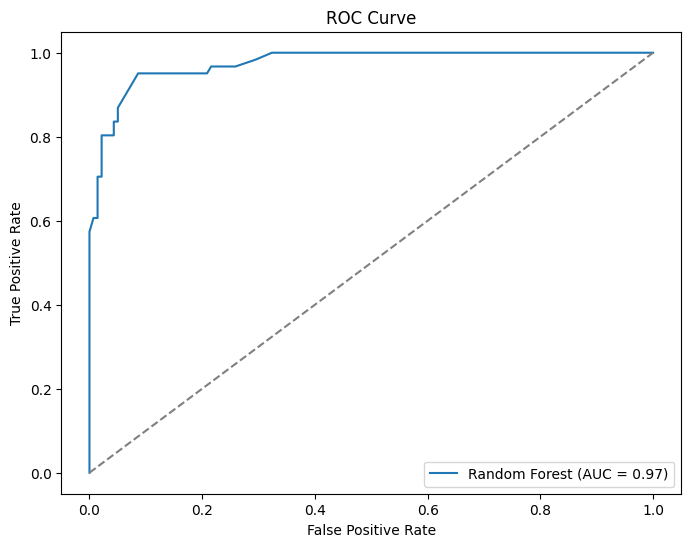

2025-01-20 23:54:53.479 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-20 23:54:54.885 
  command:

    streamlit run C:\Users\ikgha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-01-20 23:54:54.887 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-20 23:54:54.893 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-20 23:54:54.897 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-20 23:54:55.217 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-20 23:54:55.220 Thread 'MainThread': missing ScriptRunContext! This w

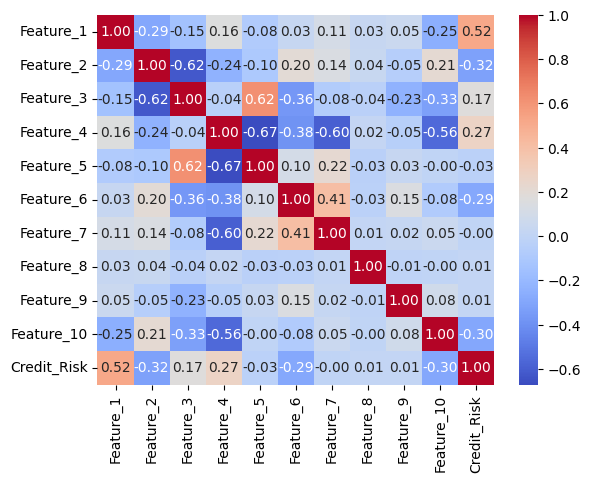

In [17]:
# Main workflow
def main():
    # Generate data
    data = generate_synthetic_data()
    data.to_csv("data/synthetic_credit_risk_data.csv", index=False)  # Save raw data

    # Visualize data
    visualize_data(data)

    # Prepare data
    X_train, X_test, y_train, y_test, scaler = prepare_data(data)

    # Train models
    log_reg_model = train_logistic_regression(X_train, y_train)
    rf_model = train_random_forest(X_train, y_train)

    # Evaluate models
    log_reg_report, log_reg_auc, log_reg_proba = evaluate_model(log_reg_model, X_test, y_test)
    rf_report, rf_auc, rf_proba = evaluate_model(rf_model, X_test, y_test)

    # Save evaluation results
    results = {
        "Logistic Regression": {"Report": log_reg_report, "AUC": log_reg_auc},
        "Random Forest": {"Report": rf_report, "AUC": rf_auc}
    }
    pd.DataFrame(results).to_csv("data/model_performance.csv")

    # Plot ROC curves
    plot_roc_curve(y_test, log_reg_proba, "Logistic Regression")
    plot_roc_curve(y_test, rf_proba, "Random Forest")

    # Streamlit dashboard
    create_dashboard(data, rf_model, scaler)

if __name__ == "__main__":
    main()

